# Skip-gram (Implementation)

In this notebook, we implement the Skip-gram version of the word2vec algorithm to generate word embeddings using an excerpt from "Alice in Wonderland" by Lewis Carroll. We start by preprocessing the text, which includes tokenizing the words and removing punctuation to create a clean corpus. Following this, we develop a vocabulary index mapping to convert words into numerical forms suitable for model input. We then create and use word-context pairs to train the neural network, aiming to predict context words from target words, thereby learning meaningful word embeddings. Each major step in the process—from data preparation to model training and evaluation—is explained within the respective sections of this notebook.

## Motivation

One-hot encoding doesn't carry much meaning - word embeddings allow us to capture relationship between words.

In CBOW, we predict a target word based on context words.

In [87]:
# Standard library imports for data manipulation
import numpy as np
import string
from sklearn.metrics.pairwise import cosine_similarity

# NLP tools for text processing
import nltk
from nltk.tokenize import word_tokenize

# Downloading NLTK resources without showing messages
nltk.download('punkt', quiet=True)

# PyTorch imports for neural network architecture and optimization
import torch
import torch.nn as nn
import torch.optim as optim

# Visualization tools
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

## Step 1: Prepare data

In the initial step of this notebook, we prepare the data necessary for training the Skip-gram word2vec model. We start by selecting an excerpt from "Alice in Wonderland" as our corpus. The text is then processed through tokenization and cleaning, where we convert it to lowercase and remove punctuation. Subsequently, we create a vocabulary of unique words and establish an index mapping for these words, allowing us to numerically represent and manipulate the text. Finally, we generate word-context pairs, which are crucial for the Skip-gram training process, by identifying the contextual words for each target word within a defined window size.

In [88]:
corpus_path = 'corpus.txt'
with open(corpus_path, 'r', encoding='utf-8') as f:
    corpus = f.read()

print("Corpus:")
print(corpus)

Corpus:
Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, 'and what is the use of a book,' thought Alice 'without pictures or conversation?'

So she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid), whether the pleasure of making a daisy chain would be worth the trouble of getting up and picking the daisies, when suddenly a White Rabbit with pink eyes ran close by her.

There was nothing so very remarkable in that; nor did Alice think it so very much out of the way to hear the Rabbit say to itself, 'Oh dear! Oh dear! I shall be late!' (when she thought it over afterwards, it occurred to her that she ought to have wondered at this, but at the time it all seemed quite natural); but when the Rabbit actually took a watch out of its waistcoat-pocket, and looked at i

First, we must preprocess the corpus. This involves lowercasing all words, removing unnecessary punctuation, and tokenizing appropriately. We will also create a vocabulary off of this corpus, which will include all unique words.

In [89]:
# Lowercase
corpus = corpus.lower()

# Remove punctuation
translator = str.maketrans('', '', string.punctuation)
corpus = corpus.translate(translator)

# Tokenize the text
tokenized_corpus = word_tokenize(corpus)

In [90]:
# Create vocabulary
vocabulary = set(tokenized_corpus)

print("Vocabulary:", vocabulary)
print("Number of unique words:", len(vocabulary))

Vocabulary: {'fortunately', 'burning', 'rabbit', 'of', 'at', 'curiosity', 'whether', 'as', 'when', 'actually', 'could', 'hear', 'for', 'pleasure', 'see', 'on', 'to', 'shall', 'and', 'would', 'watch', 'think', 'by', 'oh', 'eyes', 'just', 'occurred', 'making', 'suddenly', 'own', 'wondered', 'twice', 'started', 'afterwards', 'itself', 'ought', 'with', 'its', 'feel', 'pictures', 'made', 'reading', 'rabbithole', 'took', 'but', 'having', 'is', 'waistcoatpocket', 'this', 'her', 'feet', 'that', 'in', 'out', 'what', 'mind', 'up', 'considering', 'remarkable', 'i', 'without', 'much', 'get', 'white', 'she', 'thought', 'hurried', 'was', 'so', 'use', 'sleepy', 'or', 'trouble', 'well', 'field', 'have', 'pop', 'there', 'book', 'either', 'under', 'worth', 'sister', 'pink', 'down', 'it', 'conversation', 'quite', 'after', 'take', 'across', 'a', 'very', 'hot', 'tired', 'over', 'ever', 'do', 'did', 'then', 'into', 'dear', 'daisies', 'all', 'natural', 'peeped', 'looked', 'no', 'ran', 'picking', 'conversatio

Now that we have processed our corpus and retrieved a vocabulary, we must also retrieve the contexts of each word. We do this by finding the surrounding words of the target word in different sentences, defined by some window size. Let's choose a window size of 4.

In [91]:
window_size = 4
def build_word_context_pairs(tokenized_corpus=tokenized_corpus, vocabulary=vocabulary, window_size=window_size):
    word_context_pairs = {word: [] for word in vocabulary}
    
    for index, target_word in enumerate(tokenized_corpus):
        if target_word in vocabulary:
            start_index = max(index - window_size, 0)
            end_index = min(index + window_size + 1, len(tokenized_corpus))
            
            context_words = [tokenized_corpus[i] for i in range(start_index, end_index) if i != index]
            word_context_pairs[target_word].extend(context_words)
            
    return word_context_pairs
    
word_context_pairs = build_word_context_pairs()     
print("Context pairs for 'alice':", word_context_pairs['alice'])
print("Context pairs for 'natural':", word_context_pairs['natural'])
print("Context pairs for 'conversations':", word_context_pairs['conversations'])

Context pairs for 'alice': ['was', 'beginning', 'to', 'get', 'of', 'a', 'book', 'thought', 'without', 'pictures', 'or', 'conversation', 'in', 'that', 'nor', 'did', 'think', 'it', 'so', 'very', 'and', 'then', 'hurried', 'on', 'started', 'to', 'her', 'feet']
Context pairs for 'natural': ['it', 'all', 'seemed', 'quite', 'but', 'when', 'the', 'rabbit']
Context pairs for 'conversations': ['had', 'no', 'pictures', 'or', 'in', 'it', 'and', 'what']


Now that we have prepared our vocabulary into words to context pairs, let's encode these words so they be fed into the model. Instead of traditional one-hot-encoding, word2vec typically uses more efficient representation due to the high computational costs associated with handling large vocabularies. In this case, we will use index mapping. We do this so the data can be converted to a numerical form that can be understood by neural networks.

In [92]:
def create_index_mapping(vocabulary):
    word_to_index = {word: i for i, word in enumerate(vocabulary)}
    index_to_word = {i: word for word, i in word_to_index.items()}
    return word_to_index, index_to_word

word_to_index, index_to_word = create_index_mapping(vocabulary)

Finally, we can use these encoded pairs to set up the training data.

In [93]:
def get_training_data(word_context_pairs, word_to_index):
    training_data = []
    for word, contexts in word_context_pairs.items():
        word_idx = word_to_index[word]
        context_indices = [word_to_index[context] for context in contexts]
        for context_idx in context_indices:
            training_data.append((word_idx, context_idx))
    return np.array(training_data, dtype='int32')

training_data = get_training_data(word_context_pairs, word_to_index)
print(training_data[0:10])

[[  0  74]
 [  0  88]
 [  0  85]
 [  0  18]
 [  0  67]
 [  0  25]
 [  0  52]
 [  0 126]
 [  1  53]
 [  1   3]]


## Step 2: Define and Train Model

Now that we have encoded word-context pairs (for example (21, 3), (68, 7), (21, 10), (42, 18)), where the left integer is an encoded target word and the right integer is one of its encoded context words, we can use this data to train a model to predict relationships. We do this through a technique called **negative sampling**, involving:
- First, a true pair is fed to the model (e.g (21, 3), where 21 is the target and 3 is a true context). 
- Second, we also sample other words from the vocabulary that act as 'negative' examples. These are words that are not in the actual context of the target word. So for example, say we sample the words represented by 10, 7, and 18, then we would have (21, 10), (21, 7), and (21, 18), where these pairs are not actual contexts.
- Third, the model is tasked to distinguish between the real (positive) pairs and the fake (negative) pairs. It must learn to identify that (21, 3) is an actual word-context pair while the others are not. It should learn to predict high probabilities for actual context words and low probabilities for the negative samples.
- Fourth, note that the model does this by optimizing a binary classification objective, where the model predicts whether a given pair is likely to be a true contextual relationship or not. The model adjusts its parameters to maximize the likelihood of true context words and minimize the likelihood of the negative samples. This effectively trains the model's embeddings to capture meaningful semantic relationships between words.

Motivation: By using negative sampling in this way, we are able to make training more computationally efficient. Instead of guessing the correct context word among all vocabulary words, it has a smaller subset to choose from. It's sort of like giving the model a multiple choice quiz.


In [94]:
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.output_layer = nn.Linear(embedding_dim, 1)
        
    def forward(self, word_indices):
        embeds = self.embedding(word_indices)
        out = self.output_layer(embeds)
        probabilities = torch.sigmoid(out)
        return probabilities

Let's walk through the architecture of the model to better understand it:
- **Embedding Layer**: The embedding layer's primary role is to learn a dense, lower-dimensional representation of words. You can think of it as a lookup table, where the index associated with each word corresponds to a row in the matrix of parameters (the embedding matrix). This row gives us the word embedding of the corresponding word. Mathematically, :

In [95]:
vocab_size = len(vocabulary)
embedding_dim = 100
model = SkipGramModel(vocab_size, embedding_dim)

In [96]:
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [97]:
num_epochs = 500

for epoch in range(num_epochs):
    total_loss = 0
    for context, target in training_data:
        # Zero the gradients
        model.zero_grad()

        # Forward pass
        # Ensure context is wrapped in a tensor and has the correct shape
        log_probs = model(torch.tensor([context], dtype=torch.long))

        # Compute loss
        # Ensure target is a float tensor and reshaped to match the output dimensions
        loss = loss_function(log_probs, torch.tensor([float(target)], dtype=torch.float).unsqueeze(1))

        # Backpropagation
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    if epoch % 25 == 0:    
        print(f"Epoch {epoch}, Loss: {total_loss}")

Epoch 0, Loss: -115793.54567736387
Epoch 25, Loss: -126840.82556569576
Epoch 50, Loss: -126841.22239243984
Epoch 75, Loss: -126841.36751684546
Epoch 100, Loss: -126841.44470137358
Epoch 125, Loss: -126841.4921887815
Epoch 150, Loss: -126841.52516523004
Epoch 175, Loss: -126841.55044332147
Epoch 200, Loss: -126841.56961923838
Epoch 225, Loss: -126841.58351826668
Epoch 250, Loss: -126841.59571823478
Epoch 275, Loss: -126841.6054289937
Epoch 300, Loss: -126841.61367946863
Epoch 325, Loss: -126841.62157016993
Epoch 350, Loss: -126841.6284917593
Epoch 375, Loss: -126841.63403594494
Epoch 400, Loss: -126841.63879066706
Epoch 425, Loss: -126841.64327436686
Epoch 450, Loss: -126841.6470092535
Epoch 475, Loss: -126841.65097260475


## Step 3: Get Word Embeddings
Now that our model has finished training, we should be able to extract the word embeddings for our vocabulary by using the parameters of the model.

In [98]:
# Retrieve the embeddings from the model's embedding layer
embeddings = model.embedding.weight.data.numpy()
print("Embedding shape:", embeddings.shape)

Embedding shape: (136, 100)


In [99]:
alice_index = word_to_index["alice"]
alice_embedding = model.embedding.weight.data[alice_index].numpy()  # Convert tensor to numpy array for easy handling
print("Embedding for 'alice':", alice_embedding)

Embedding for 'alice': [ 1.3281476   1.6786677   0.5328159   0.2368449  -0.77496624 -0.7776644
  1.1907684  -0.71478605  0.41524374  0.59369993 -0.3123732   1.5897223
 -3.1046684   0.8947813  -1.3367102  -0.8794013  -1.0088012   2.1058748
  1.3851062   0.6147263  -1.1490349   1.2073033   0.11819471 -0.01759757
  0.5751674   1.0808225   0.20658608 -1.5149641   0.93364644 -0.9782125
  0.7166617  -1.0553639   0.3604726   0.06957695 -0.38224557 -1.426718
 -1.4147228  -0.12763359  0.8131563  -0.0526088   1.223233   -0.40587828
 -0.07032851  1.5358198   0.06985587 -0.5844128  -1.1898117  -0.6926599
  0.796856    1.52396     0.2187719  -1.239312   -0.38235506 -2.1553593
 -0.39662203  0.1983159  -2.0871606  -0.30445015  0.5275204  -1.0904926
  1.906297    1.0006603   0.775701   -2.0779068   0.27533913 -0.48251942
 -1.617526   -0.05871161  1.1396227   0.7121244  -0.00860345 -0.33231926
  0.72079355  0.35260814 -0.2581768   0.06063668 -0.7024979   1.525917
  0.38352826  0.02955903 -0.19909416  0

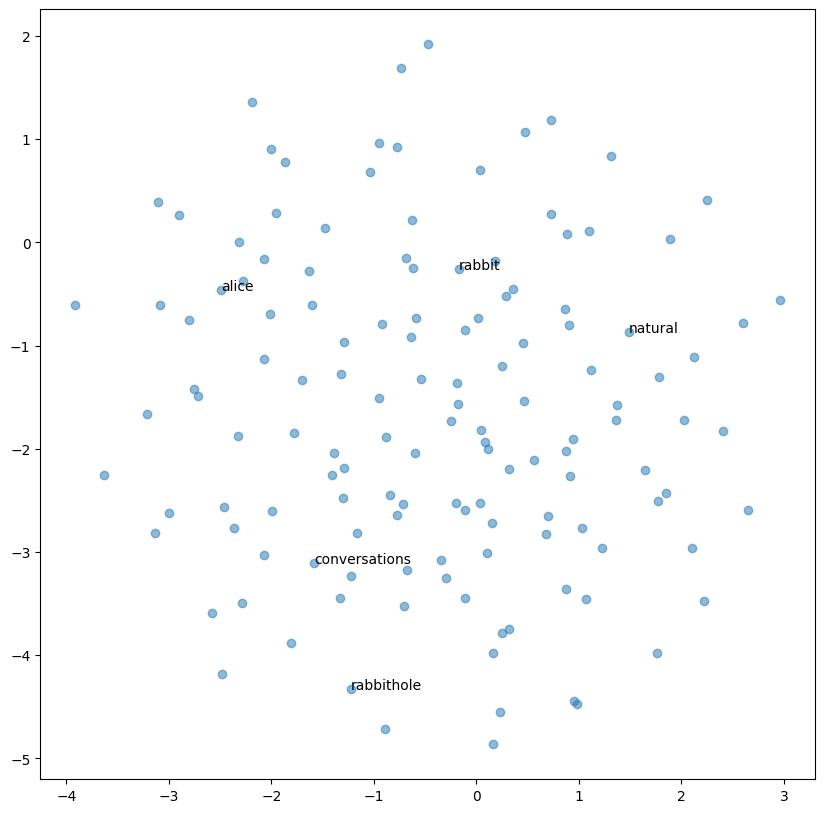

In [100]:
# Perform t-SNE dimensionality reduction to visualize embedding space
tsne = TSNE(n_components=2, perplexity=30, max_iter=3000)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)

# Annotate a few interesting words
words = ['alice', 'natural', 'conversations', 'rabbit', 'rabbithole'] 
for word in words:
    if word in word_to_index: 
        idx = word_to_index[word]
        plt.annotate(word, (embeddings_2d[idx, 0], embeddings_2d[idx, 1]))

plt.show()

In [101]:
def find_nearest_neighbors(word, embeddings, word_to_index, index_to_word, top_n=5):
    word_index = word_to_index[word]
    word_embedding = embeddings[word_index].reshape(1, -1)
    similarities = cosine_similarity(word_embedding, embeddings).flatten()
    nearest_indices = similarities.argsort()[-top_n-1:-1][::-1]  # Skip the word itself
    nearest_words = [(index_to_word[idx], similarities[idx]) for idx in nearest_indices]
    return nearest_words

In [102]:
neighbors = find_nearest_neighbors('alice', embeddings, word_to_index, index_to_word)
print("Nearest Neighbors of 'alice':", neighbors) 

Nearest Neighbors of 'alice': [('actually', 0.19799063), ('made', 0.1927574), ('ran', 0.18095517), ('hedge', 0.14952956), ('dear', 0.1489453)]


## Conclusion

In this notebook, we successfully implemented the Skip-gram model of the word2vec algorithm using a small excerpt from "Alice in Wonderland." By focusing on this concise dataset, we were able to build a foundational understanding of how word embeddings are generated and how they capture syntactic and semantic word relationships within a text. The embeddings generated provided us with a preliminary insight into the contextual relevance of words, demonstrating the model's ability to associate words with their usage in specific narrative contexts. This exercise has not only enhanced our intuition about neural word embeddings but also set the stage for further explorations into more sophisticated natural language processing tasks using larger and more complex datasets.